# Time Series Forecasting w/ RNN Seq2Seq Models

   > Based on model design from: https://github.com/guillaume-chevalier/seq2seq-signal-prediction

In [1]:
# Compatibility between Python 2.7 and 3.x
from __future__ import unicode_literals, print_function, division
from io import open
# Wrangling
import glob # Files
import os # Files
import numpy as np # Arrays
import pandas as pd # DataFrames
# Preprocessing
from sklearn.preprocessing import StandardScaler # Centers mean at zero, applies unit variance
# Visualization
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
# Modeling
import tensorflow as tf # Deep Learning
# Custom utility functions shared across notebooks
import utils

/Users/BennyBluebird/anaconda/envs/tfpy27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/BennyBluebird/anaconda/envs/tfpy27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Loading

In [2]:
period_len = 174 # Maximum number of months for which data exists
airlines = ['AA', 'DL', 'UA'] # Airlines of interest in forecasting
passengers_df = utils.load_data(airlines, category='Passengers') # Monthly passenger counts
flights_df = utils.load_data(airlines, category='Flights') # Monthly flight counts
asm_df = utils.load_data(airlines, category='ASM') # Monthly available seat miles
rpm_df = utils.load_data(airlines, category='RPM') # Monthly revenue passenger miles

# Fetch complete datasets only / ensure that 174 months of data exist for dataframes in each category
assert passengers_df.shape[1] == flights_df.shape[1] == asm_df.shape[1] == rpm_df.shape[1] == period_len

## Model Graph Definition

### Model & Parameters

In [239]:
# Load paths to TF seq2seq model and recurrent cells to be used in this project
tf.nn.seq2seq = tf.contrib.legacy_seq2seq
tf.nn.rnn_cell = tf.contrib.rnn 
tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell # Useful for learning long-range dependencies in sequences

# Data shape parameters
batch_size = 3 # How many time series to train on before updating model's weight parameters
output_seq_len = 12 # How many months to predict into the future
input_seq_len = period_len - output_seq_len # How many months to train on in the past

# Internal neural network parameters
input_dim = output_dim = 1 # Univariate time series (predicting future values based on stream of historical values)
hidden_dim = 100  # Number of neurons in each recurrent unit 
num_layers = 2  # Number of stacked recurrent cells (number of recurrent layers)

# Optimizer parameters
learning_rate = 0.005  # Small lr helps not to diverge during training. 
epochs = 1000  # How many times we perform a training step (how many times we show a batch)
lr_decay = 0.9  # default: 0.9 . Simulated annealing.
momentum = 0.2  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - reduces overfitting

# Declare which airline-airport time series will be used for testing
airline_airports = [('AA', 'DFW'), ('DL', 'ATL'), ('UA', 'ORD')]
# Exclude them from training phase
excluded = map('-'.join, airline_airports)
# Allow fetching of same three samples during validation
random_state = 42

### Input, Hidden, & Output Layers

In [240]:
# Reset any existing graph, close any previous session, discard old variables, and start fresh
tf.reset_default_graph()
if 'sess' in globals():
    sess.close()
sess = tf.InteractiveSession()
tf.set_random_seed(random_state)

with tf.variable_scope('Seq2Seq'):
    # Input values to encoder RNN
    encoder_inputs = [tf.placeholder(tf.float32, shape=(None, input_dim), 
                     name="encoder_input_{}".format(t)) for t in range(input_seq_len)]
    
    # Target values for decoder RNN
    decoder_targets = [tf.placeholder(tf.float32, shape=(None, output_dim), 
                       name="decoder_target_{}".format(t)) for t in range(output_seq_len)]
    
    # Feed final n encoder inputs into the decoder RNN, where n = output_seq_len
    # "GO", represented by 0, starts the decoder
    decoder_inputs = [tf.zeros_like(encoder_inputs[0], dtype=np.float32, name="GO")] +\
                      encoder_inputs[-(output_seq_len - 1):]
    
    # Stack hidden recurrent layers
    cells = list()
    for i in range(num_layers):
        with tf.variable_scope('RNN_' + str(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    # Pass encoder and decoder inputs through model, retrieving output from the decoder at each prediction step
    decoder_outputs, decoder_state = tf.nn.seq2seq.basic_rnn_seq2seq(encoder_inputs, decoder_inputs, cell)
    
    # Squeeze decoder output into a single value, representing the forecast at that point in the sequence
    W_out = tf.Variable(tf.truncated_normal([hidden_dim, output_dim], seed=random_state)) # Output weight matrix
    b_out = tf.Variable(tf.truncated_normal([output_dim], seed=random_state)) # Output bias
    
    # Apply a trainable, constant linear transformation to final outputs
    output_scale_factor = tf.Variable(1.0, name="Output_Scale_Factor")
    reshaped_outputs = [output_scale_factor * (tf.matmul(i, W_out) + b_out) for i in decoder_outputs]

### Loss Function & Optimizer

In [241]:
with tf.variable_scope('Loss'):
    # Compute L2 loss for output at each time step: 
    # https://www.tensorflow.org/api_docs/python/tf/nn/l2_loss
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, decoder_targets):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
    # Penalize model complexity with L2 regularization
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
    # Add regularization term to loss function        
    loss = output_loss + lambda_l2_reg * reg_loss
    
with tf.variable_scope('Optimizer'):
    # Search for minimum of loss function with RMSProp:
    # https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum, centered=True)
    train_op = optimizer.minimize(loss)

## Training & Testing Functions

### Training

In [242]:
def train_batch(df, batch_size, output_seq_len, excluded):
    """
    Trains session model, attempting to optimize internal weight parameters
    to accurately predict the number of steps into future given by output_seq_len
    
    @df: DataFrame to sample random time series from (Passengers, Flights, ASM, RPM)
    @batch_size: How many time series to sample at a time
    @output_seq_len: How many months to reserve for prediction (training target)
    """
    _, X_train, y_train = utils.fetch_sample(df=df, batch_size=batch_size, output_seq_len=output_seq_len, excluded=excluded)
    feed_dict = {encoder_inputs[t]: X_train[t] for t in range(len(encoder_inputs))}
    feed_dict.update({decoder_targets[t]: y_train[t] for t in range(len(decoder_targets))})
    _, train_loss = sess.run([train_op, loss], feed_dict)
    return train_loss

### Testing

In [282]:
DATES = pd.date_range(start='2016-04-01', end='2017-03-01', freq='MS').to_pydatetime()

def test_batch(df, batch_size, output_seq_len, random_state=None, viz=False):
    """
    Tests session model on a batch of random time series drawn from one of the metrics DataFrames.
    All passed parameters should be same as those used during training.
    
    @df: DataFrame to sample random time series from (Passengers, Flights, ASM, RPM)
    @batch_size: How many time series to sample at a time
    @output_seq_len: How many months to set aside for prediction (training target)
    @random_state: Controls reproducible output
    @viz: Whether to produce visual comparision or simply return test loss
    """
    scaler, X_test, y_test = utils.fetch_sample(df=df, output_seq_len=output_seq_len, 
                              batch_size=batch_size, random_state=random_state)
    feed_dict = {encoder_inputs[t]: X_test[t] for t in range(len(encoder_inputs))}
    feed_dict.update({decoder_targets[t]: y_test[t] for t in range(len(decoder_targets))})
    test_loss = sess.run([loss], feed_dict)
    
    if viz:
        preds = np.array(sess.run([reshaped_outputs], feed_dict)[0])
        real_X_test = np.exp(scaler.inverse_transform(X_test.reshape(-1, 3)))
        real_y_test = np.exp(scaler.inverse_transform(y_test.reshape(-1, 3)))
        real_preds = np.exp(scaler.inverse_transform(preds.reshape(-1, 3)))

        label_0 = "Past (training) Values"
        label_1 = "Future (target) Values"
        label_2 = "Future (predicted) values"

        for i in range(X_test.shape[1]):
            MAPE_score = utils.MAPE(real_y_test[:,i], real_preds[:,i])
            plt.figure(figsize=(20, 8))
            plt.grid(True)
            plt.plot(range(len(real_X_test)), real_X_test[:,i], "o--b", label=label_0, ms=10)
            plt.plot(range(len(real_X_test), len(real_X_test) + len(real_y_test)), real_y_test[:,i], '*--', c='#ee7600', label=label_1, ms=10)
            plt.plot(range(len(real_X_test), len(real_X_test) + len(real_preds)), real_preds[:,i], '^--', c='#0d7629', label=label_2, ms=10)
            plt.xlabel("Month Number")
            plt.ylabel("Monthly {}".format(df.index.name))
            plt.legend(loc='best', fontsize=20)
            if i == 0:  
                plt.title("Seq2Seq RNN // Sideways - Major Spike (MAPE = {})%".format(MAPE_score), fontsize=20)
            elif i == 1:
                plt.title("Seq2Seq RNN // Downtrend - Sideways (MAPE = {})%".format(MAPE_score), fontsize=20)
            else:
                plt.title("Seq2Seq RNN // Sideways - Minor Spike (MAPE = {})%".format(MAPE_score), fontsize=20)
            plt.show()
            
    else:
        return test_loss[0]
        
def test_series(df, airline, airport, output_seq_len):
    """
    Tests session model on a specific airline-airport series, visually comparing
    actual values to forecasted values and displaying MAPE score. DataFrame
    and output_seq_len should be same as those used during training.
    
    @df: DataFrame to draw specific time series from (Passengers, Flights, ASM, RPM)
    @airline: IATA airline code (AA, DL, UA, etc.)
    @airport: IATA airport code (ATL, DFW, ORD, etc.)
    @output_seq_len: How many months to reserve for prediction (test targets)
    """
    
    scaler, X_test, y_test = utils.load_test_series(
        df=df, airline=airline, airport=airport, output_seq_len=output_seq_len)
    X_test = X_test.reshape(-1, 1, 1)
    y_test = y_test.reshape(-1, 1, 1)
    feed_dict = {encoder_inputs[t]: X_test[t] for t in range(len(encoder_inputs))}
    preds = np.array(sess.run([reshaped_outputs], feed_dict)[0])
    
    real_X_test = np.exp(scaler.inverse_transform(X_test))
    real_y_test = np.exp(scaler.inverse_transform(y_test))
    real_preds = np.exp(scaler.inverse_transform(preds))
    
    MAPE_score = utils.MAPE(real_y_test, real_preds)
    
    label_0 = "Future (target) Values"
    label_1 = "Future (predicted) values"
    title = "Seq2Seq RNN // {0}-{1}: Monthly {2} (MAPE = {3}%)".format(airline, airport, df.index.name, MAPE_score)
    
    plt.figure(figsize=(20, 8))
    plt.plot(DATES, real_y_test[:,0], '*--', c='#ee7600', label=label_0, ms=20)
    plt.plot(DATES, real_preds[:,0], '^--', c='#0d7629', label=label_1, ms=20)
    plt.xlabel("Date (YYYY-MM)")
    plt.ylabel("Monthly {}".format(df.index.name))
    plt.legend(loc='best', fontsize=20)
    plt.title(title, fontsize=20)
    plt.setp(plt.xticks()[1], rotation=45, fontsize=14)
    plt.savefig('test_series-{}-{}'.format(airline, airport))
    plt.show()

## Passengers Forecasting

### Passengers training

In [248]:
# Reset variables and run passengers training ops
sess.run(tf.global_variables_initializer())
for t in range(epochs + 1):
    train_loss = train_batch(df=passengers_df, batch_size=batch_size, output_seq_len=output_seq_len, excluded=excluded)
    # Taking the dev_loss on the same random samples serves as a validation run every 100 training runs
    if t % 100 == 0:
        dev_loss = test_batch(df=passengers_df, batch_size=batch_size, output_seq_len=output_seq_len, random_state=random_state)
        print("Step {0}/{1} \ttrain loss: {2} \tdev loss: {3}".format(t, epochs, train_loss, dev_loss))

Step 0/1000 	train loss: 106.276611328 	dev loss: 5167.95410156
Step 100/1000 	train loss: 11.0069408417 	dev loss: 6.75357246399
Step 200/1000 	train loss: 9.91995620728 	dev loss: 6.19010829926
Step 300/1000 	train loss: 5.42841339111 	dev loss: 7.18474149704
Step 400/1000 	train loss: 2.77602577209 	dev loss: 3.04996585846
Step 500/1000 	train loss: 2.37430477142 	dev loss: 2.62000966072
Step 600/1000 	train loss: 3.17716264725 	dev loss: 2.04582095146
Step 700/1000 	train loss: 2.27585506439 	dev loss: 2.13992595673
Step 800/1000 	train loss: 2.01524829865 	dev loss: 3.41816592216
Step 900/1000 	train loss: 3.74378919601 	dev loss: 2.43570184708
Step 1000/1000 	train loss: 6.18252658844 	dev loss: 3.59511828423


### Forecasting passengers for three types of time series

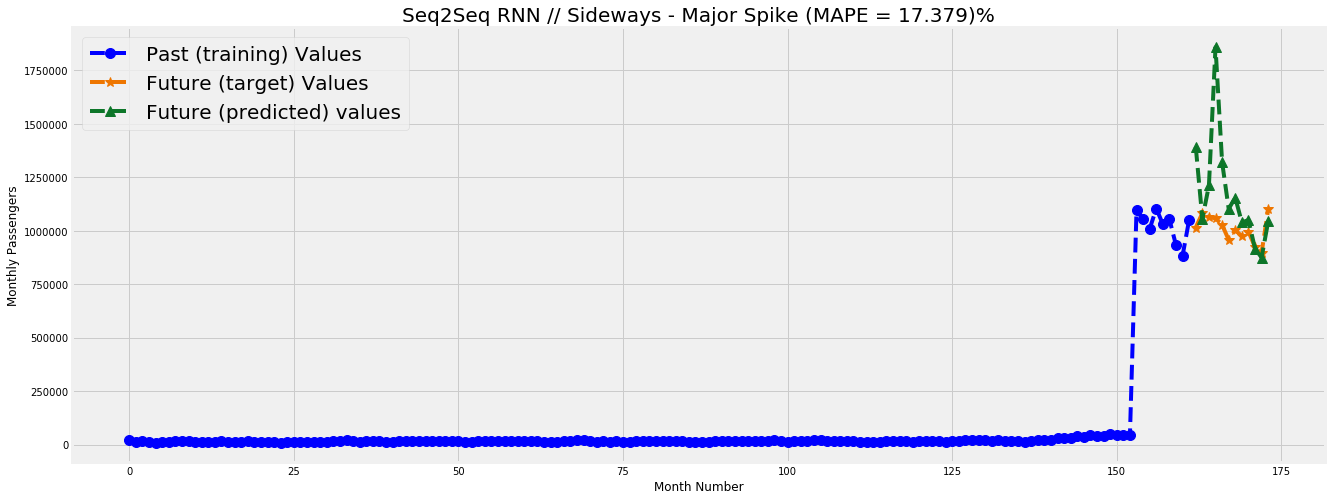

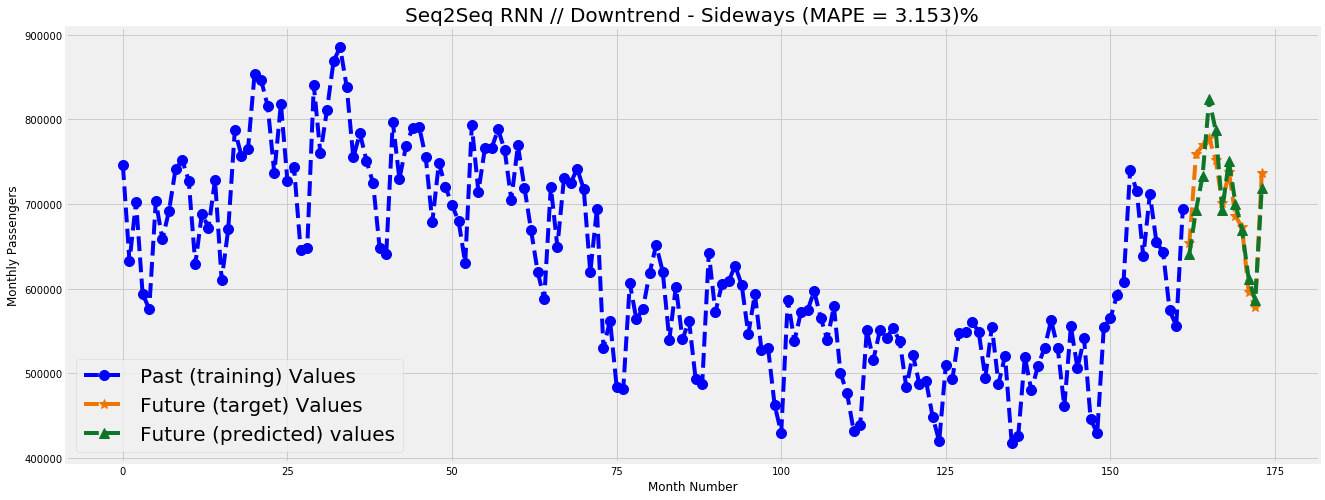

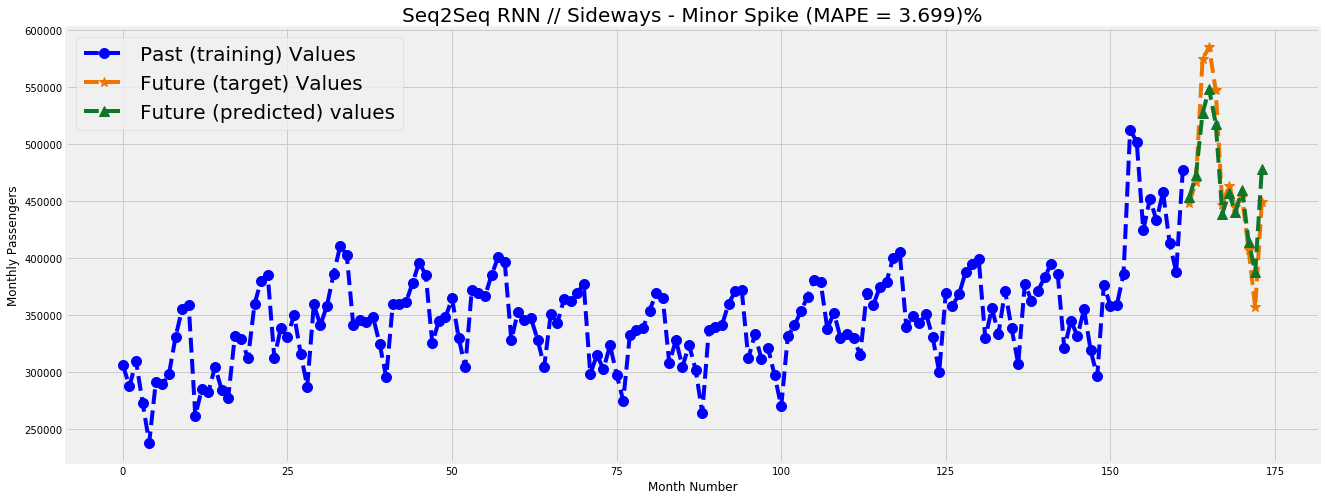

In [237]:
test_batch(df=passengers_df, batch_size=batch_size, output_seq_len=output_seq_len, random_state=21, viz=True)

### Forecasting passengers for airport-airline combinations of interest (AA-DFW, DL-ATL, UA-ORD)

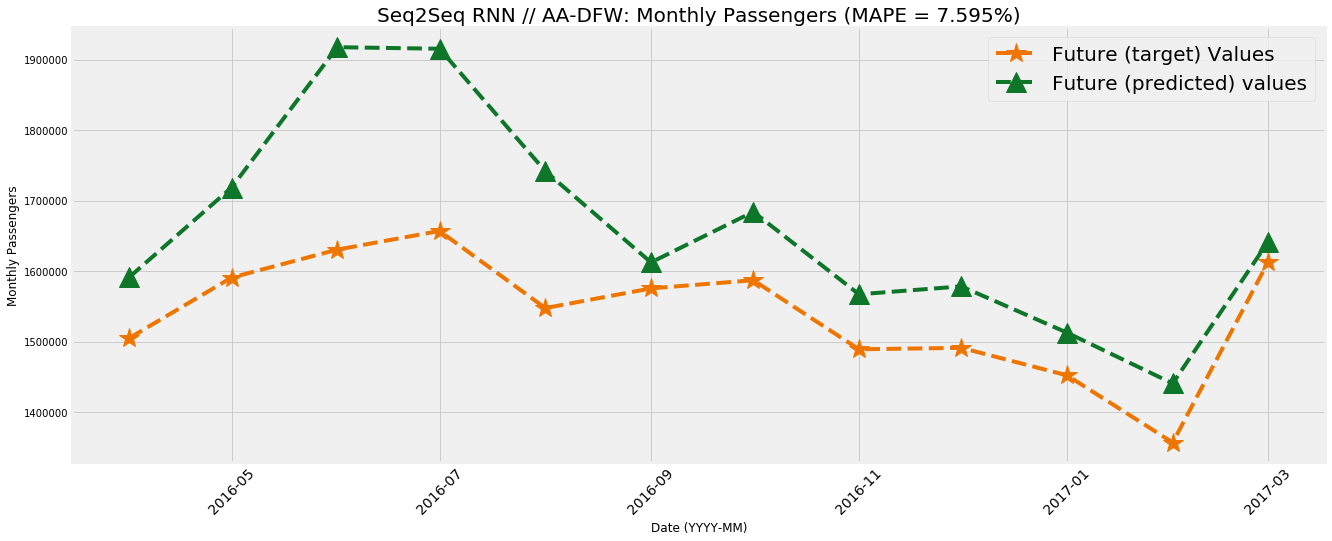

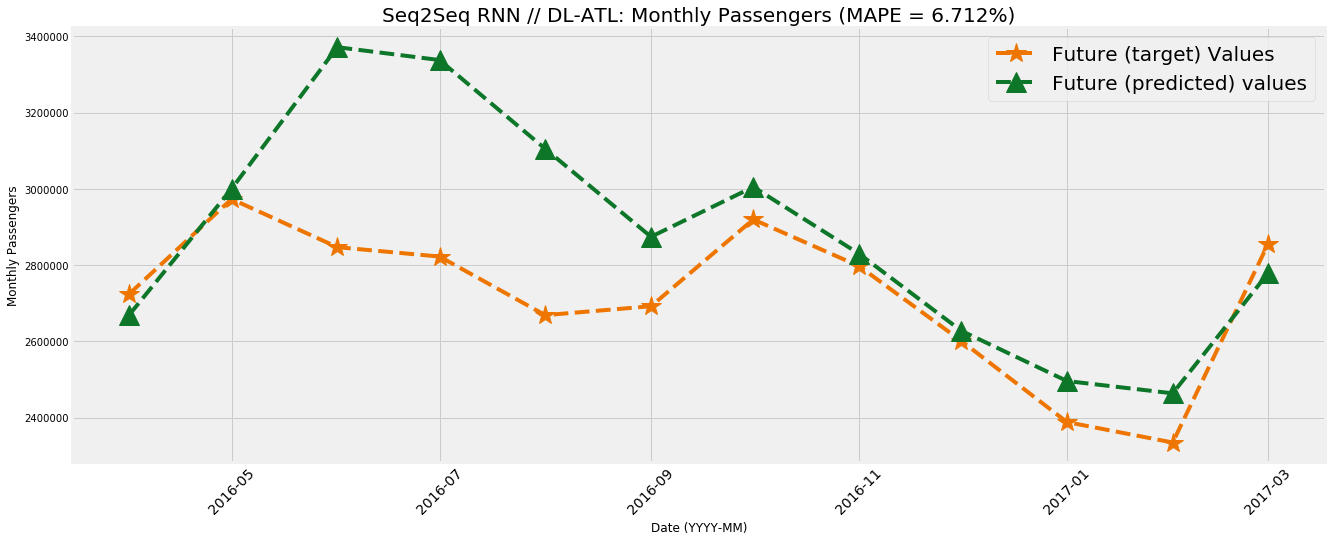

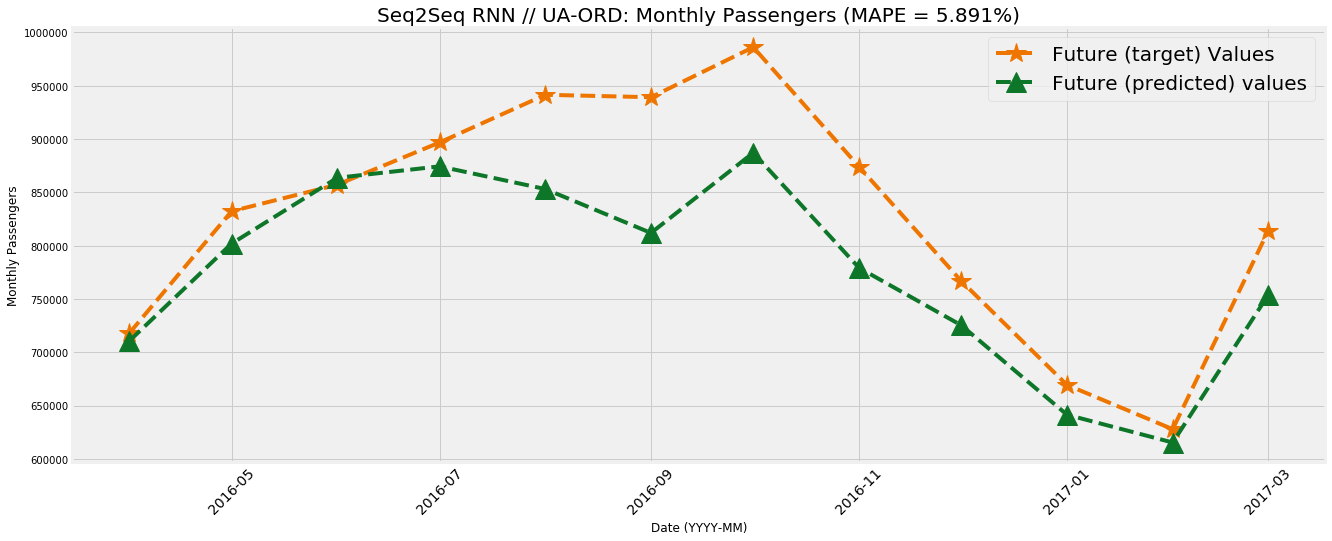

In [251]:
# Display passengers forecasts and MAPE scores for three key combinationss
for combo in airline_airports:
    airline, airport = combo
    test_series(df=passengers_df, airline=airline, airport=airport, output_seq_len=output_seq_len)

## Flights Forecasting

### Flights training

In [267]:
# Reset variables and run flights training ops
sess.run(tf.global_variables_initializer())
for t in range(epochs + 1):
    train_loss = train_batch(df=flights_df, batch_size=batch_size, output_seq_len=output_seq_len, excluded=excluded)
    if t % 100 == 0:
        dev_loss = test_batch(df=flights_df, batch_size=batch_size, output_seq_len=output_seq_len, random_state=random_state)
        print("Step {0}/{1} \ttrain loss: {2} \tdev loss: {3}".format(t, epochs, train_loss, dev_loss))

Step 0/1000 	train loss: 24.0935897827 	dev loss: 1972.58520508
Step 100/1000 	train loss: 10.2737693787 	dev loss: 13.1156549454
Step 200/1000 	train loss: 3.82281446457 	dev loss: 19.0577964783
Step 300/1000 	train loss: 19.3155517578 	dev loss: 5.06475543976
Step 400/1000 	train loss: 4.68404388428 	dev loss: 7.57293605804
Step 500/1000 	train loss: 4.7308216095 	dev loss: 7.21917152405
Step 600/1000 	train loss: 4.06517076492 	dev loss: 5.45781469345
Step 700/1000 	train loss: 3.5291030407 	dev loss: 3.54472255707
Step 800/1000 	train loss: 3.61269450188 	dev loss: 2.45914268494
Step 900/1000 	train loss: 3.21370220184 	dev loss: 2.51991653442
Step 1000/1000 	train loss: 2.64865350723 	dev loss: 3.36785936356


### Forecasting flights for airport-airline combinations of interest (AA-DFW, DL-ATL, UA-ORD)

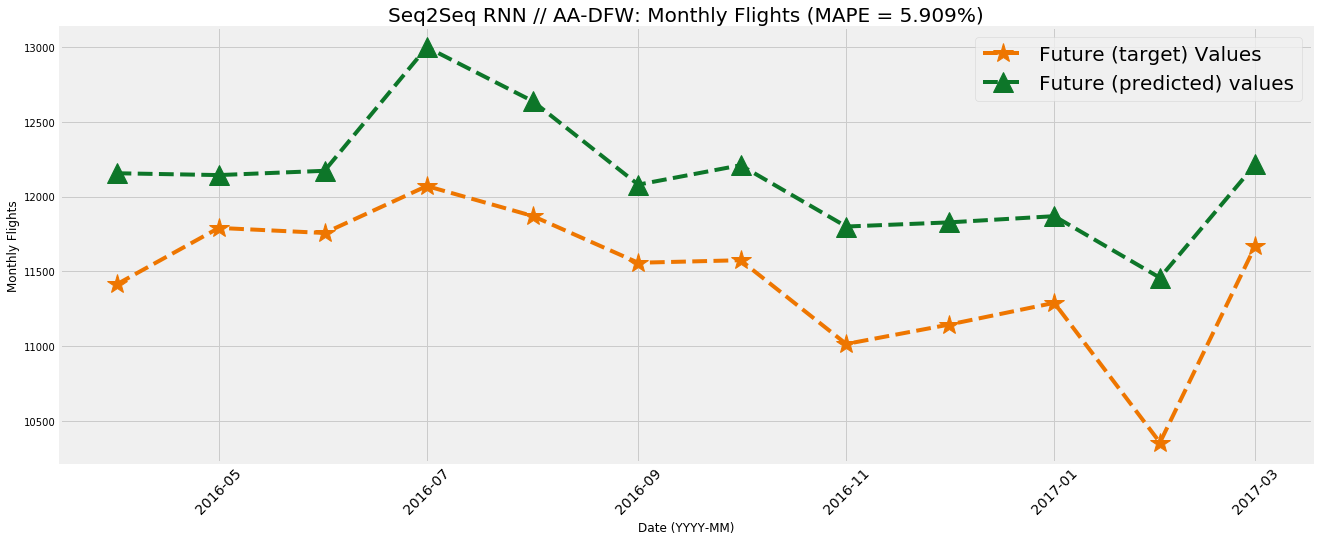

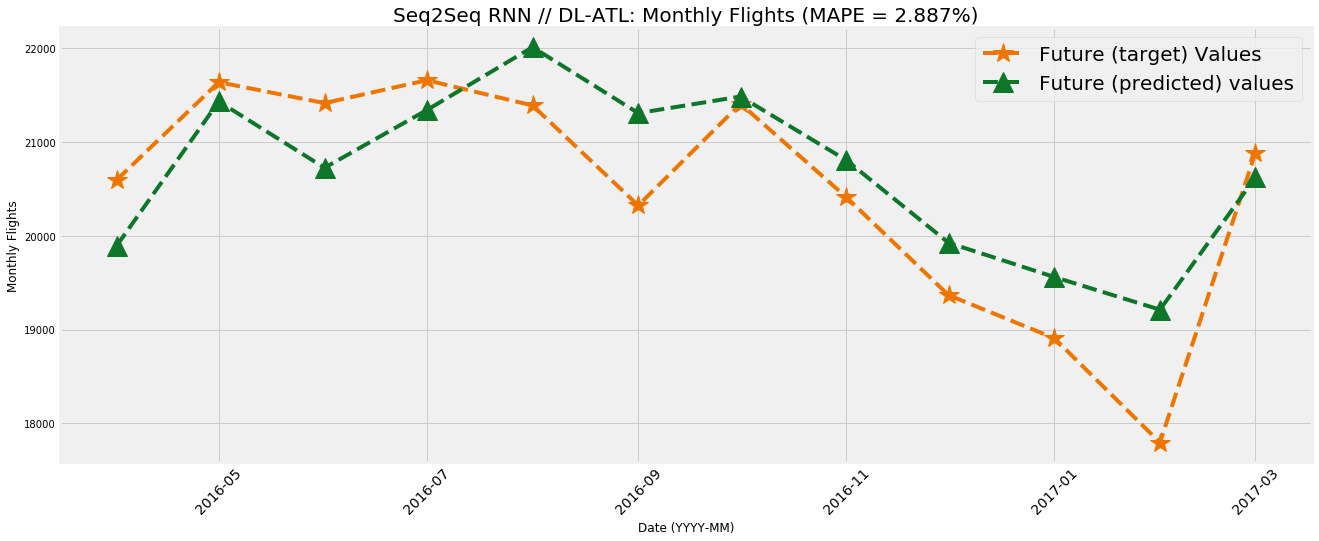

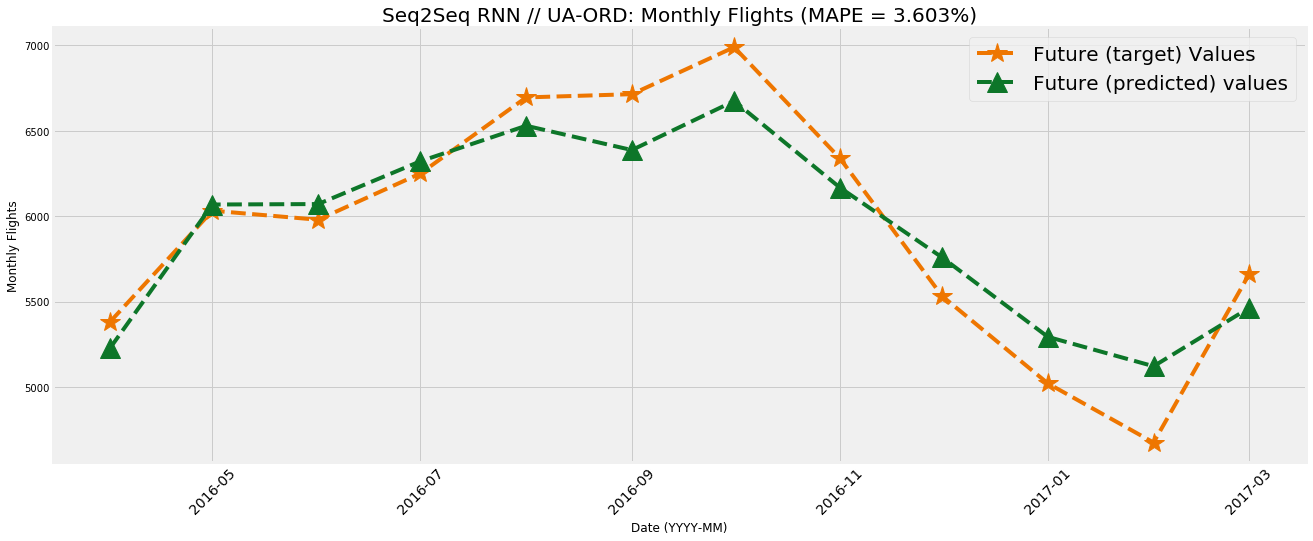

In [269]:
# Display flights forecasts and MAPE scores for three key combinations
airline_airports = [('AA', 'DFW'), ('DL', 'ATL'), ('UA', 'ORD')]
for combo in airline_airports:
    airline, airport = combo
    test_series(df=flights_df, airline=airline, airport=airport, output_seq_len=output_seq_len)

## Available Seat Miles (ASM) Forecasting

### ASM training

In [281]:
# Reset variables and run ASM training ops
sess.run(tf.global_variables_initializer())
for t in range(epochs + 1):
    train_loss = train_batch(df=asm_df, batch_size=batch_size, output_seq_len=output_seq_len, excluded=excluded)
    if t % 100 == 0:
        dev_loss = test_batch(df=asm_df, batch_size=batch_size, output_seq_len=output_seq_len, random_state=random_state)
        print("Step {0}/{1} \ttrain loss: {2} \tdev loss: {3}".format(t, epochs, train_loss, dev_loss))

Step 0/1000 	train loss: 29.0547065735 	dev loss: 4176.24169922
Step 100/1000 	train loss: 6.39495563507 	dev loss: 6.54297494888
Step 200/1000 	train loss: 14.8130598068 	dev loss: 7.65673446655
Step 300/1000 	train loss: 11.7286176682 	dev loss: 14.2677555084
Step 400/1000 	train loss: 3.25455784798 	dev loss: 5.94392204285
Step 500/1000 	train loss: 2.16203784943 	dev loss: 2.98702311516
Step 600/1000 	train loss: 2.29528331757 	dev loss: 4.54470062256
Step 700/1000 	train loss: 2.57377338409 	dev loss: 3.0186753273
Step 800/1000 	train loss: 2.15189313889 	dev loss: 3.06844091415
Step 900/1000 	train loss: 3.51338195801 	dev loss: 2.95391988754
Step 1000/1000 	train loss: 6.10994148254 	dev loss: 4.57034063339


### Forecasting ASM for airport-airline combinations of interest (AA-DFW, DL-ATL, UA-ORD)

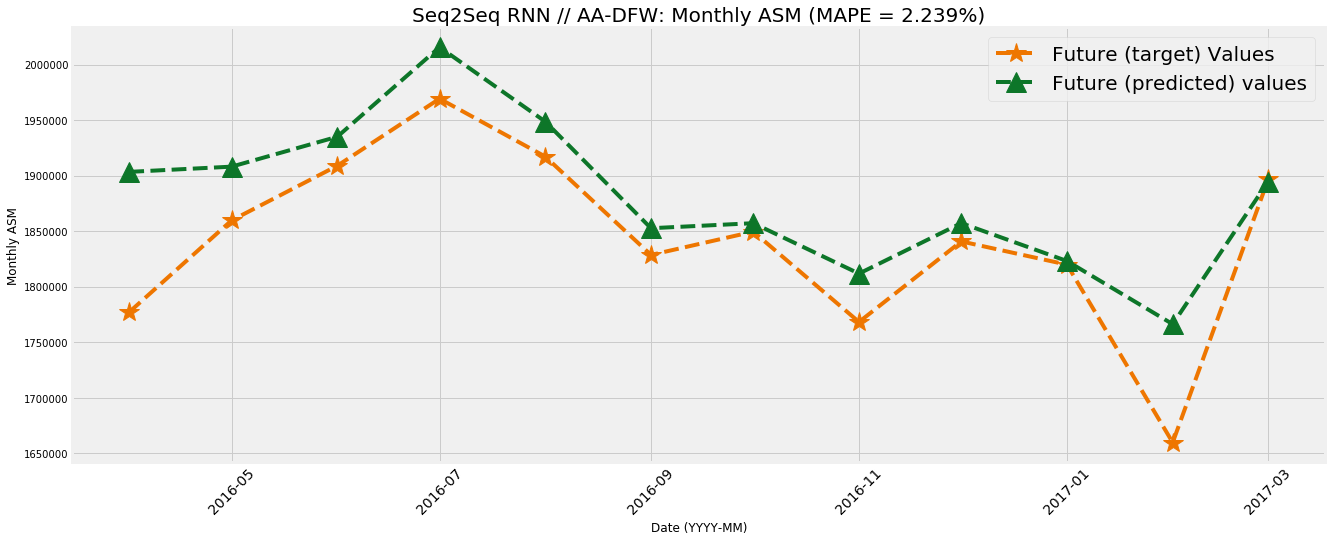

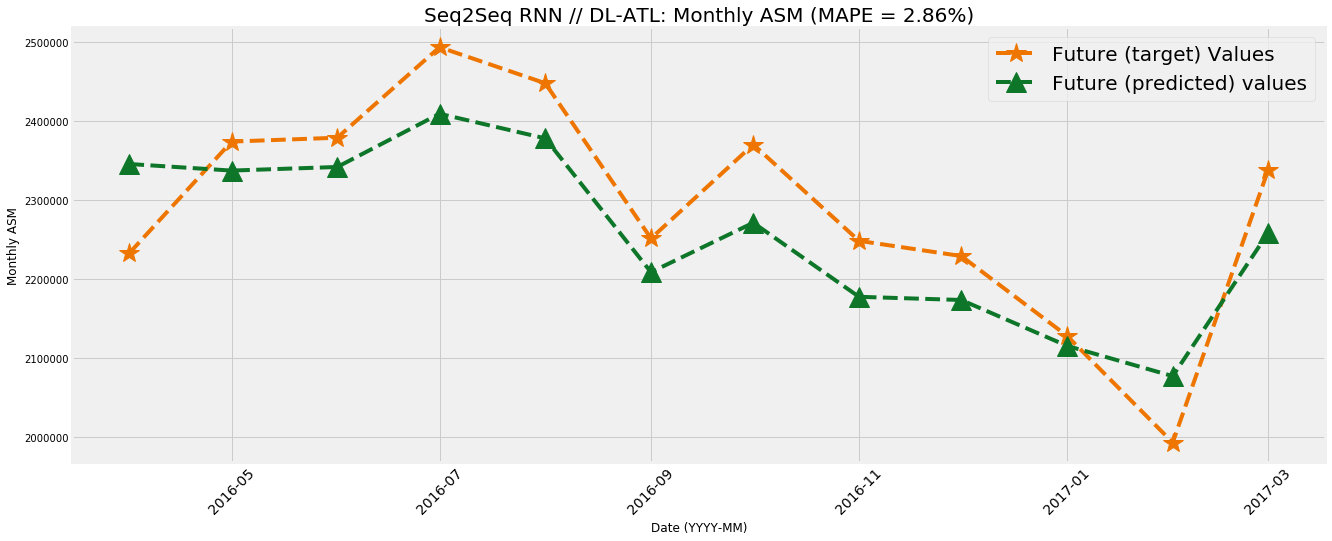

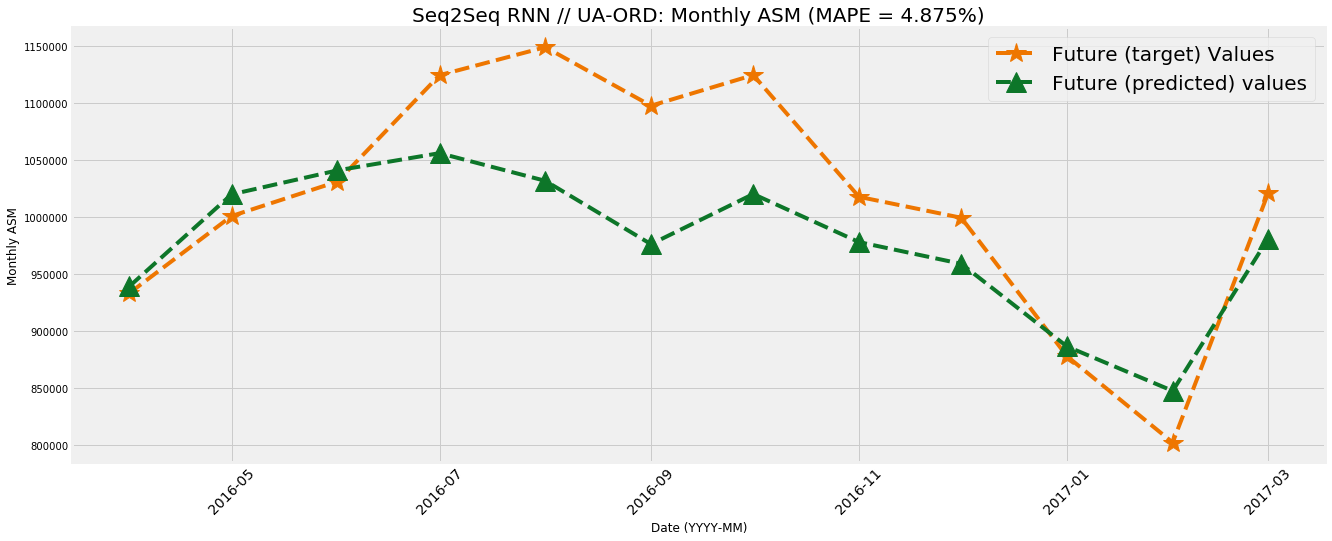

In [283]:
# Display ASM forecasts and MAPE scores for three key combinations
airline_airports = [('AA', 'DFW'), ('DL', 'ATL'), ('UA', 'ORD')]
for combo in airline_airports:
    airline, airport = combo
    test_series(df=asm_df, airline=airline, airport=airport, output_seq_len=output_seq_len)

## Revenue Passenger Miles (RPM) Forecasting

### RPM training

In [279]:
# Reset variables and run RPM training ops
sess.run(tf.global_variables_initializer())
for t in range(epochs + 1):
    train_loss = train_batch(df=rpm_df, batch_size=batch_size, output_seq_len=output_seq_len, excluded=excluded)
    if t % 100 == 0:
        dev_loss = test_batch(df=rpm_df, batch_size=batch_size, output_seq_len=output_seq_len, random_state=random_state)
        print("Step {0}/{1} \ttrain loss: {2} \tdev loss: {3}".format(t, epochs, train_loss, dev_loss))

Step 0/1000 	train loss: 41.2682380676 	dev loss: 2078.21313477
Step 100/1000 	train loss: 8.20158958435 	dev loss: 6.74152374268
Step 200/1000 	train loss: 5.60662698746 	dev loss: 8.14398384094
Step 300/1000 	train loss: 3.42990589142 	dev loss: 4.26322555542
Step 400/1000 	train loss: 12.0907001495 	dev loss: 10.8215904236
Step 500/1000 	train loss: 4.11428546906 	dev loss: 3.03039646149
Step 600/1000 	train loss: 3.16371011734 	dev loss: 2.19740462303
Step 700/1000 	train loss: 2.30751609802 	dev loss: 1.9308347702
Step 800/1000 	train loss: 1.31449007988 	dev loss: 1.78917694092
Step 900/1000 	train loss: 4.17401838303 	dev loss: 4.71662473679
Step 1000/1000 	train loss: 1.07743060589 	dev loss: 1.56947612762


### Forecasting RPM for airport-airline combinations of interest (AA-DFW, DL-ATL, UA-ORD)

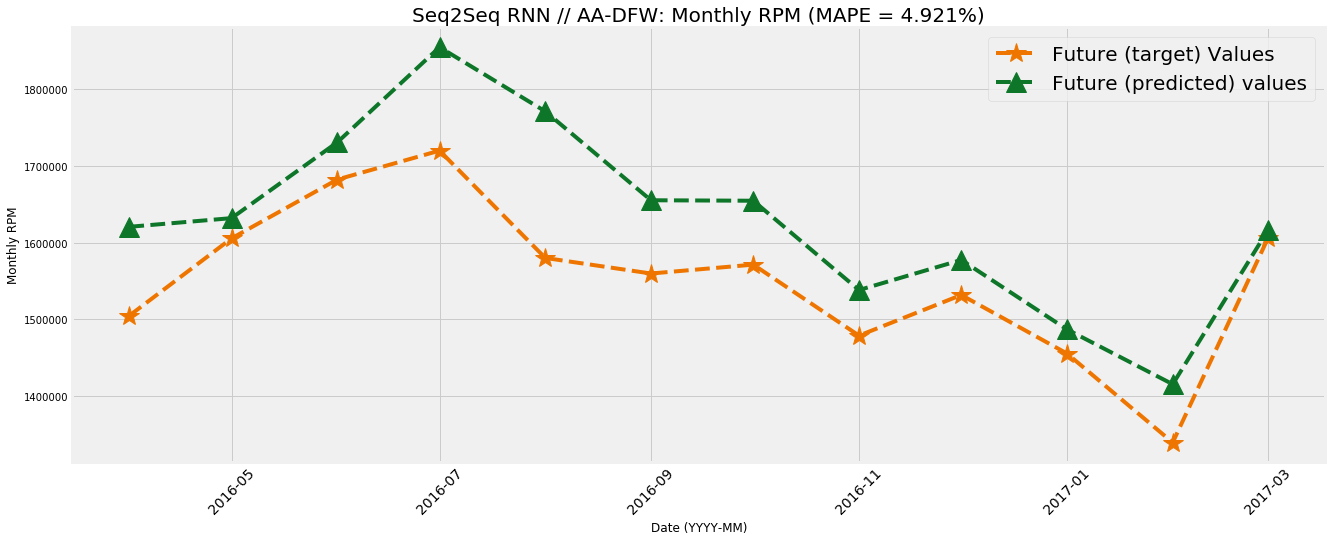

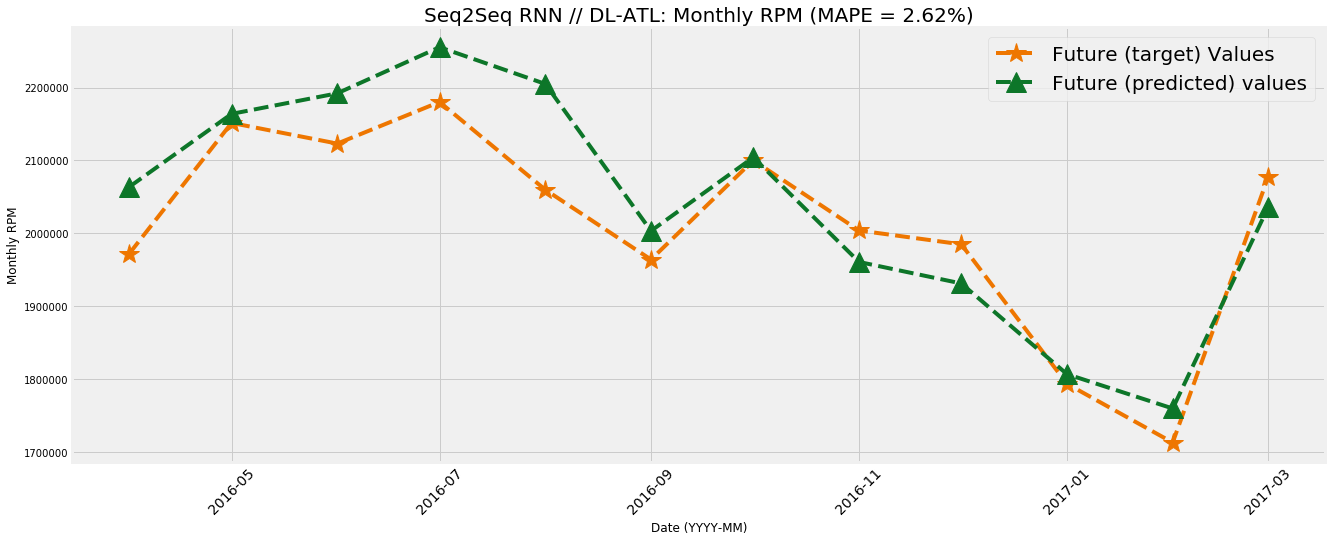

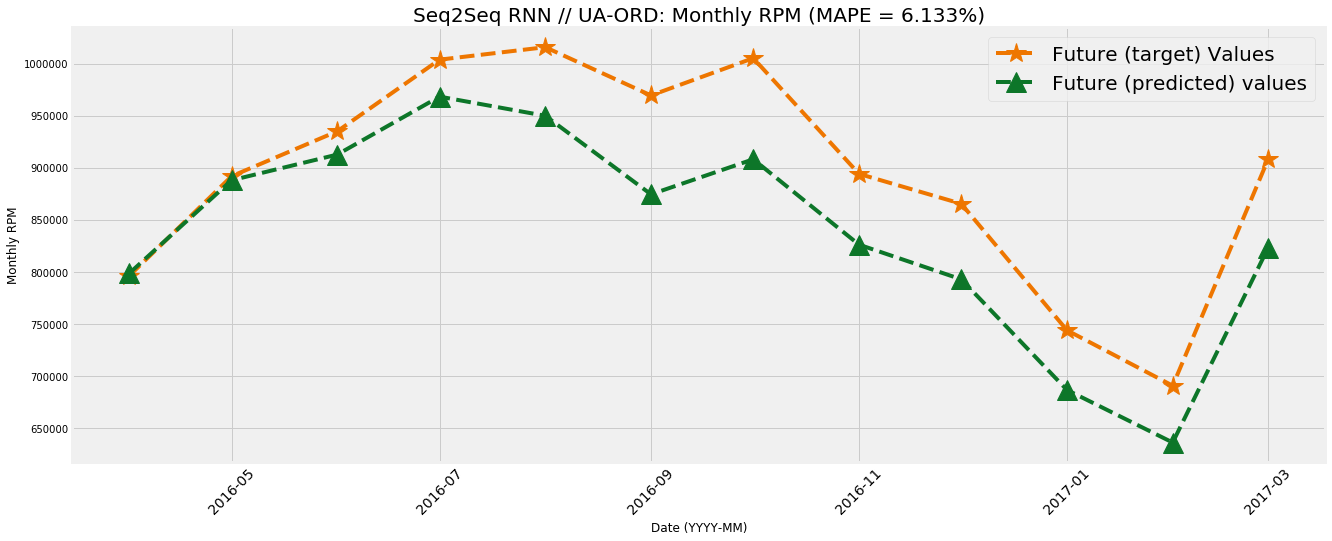

In [280]:
# Display RPM forecasts and MAPE scores for three key combinations
airline_airports = [('AA', 'DFW'), ('DL', 'ATL'), ('UA', 'ORD')]
for combo in airline_airports:
    airline, airport = combo
    test_series(df=rpm_df, airline=airline, airport=airport, output_seq_len=output_seq_len)